<a href="https://colab.research.google.com/github/McKnightA/ExperienceMachine/blob/Transformer-Architecture/full_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#set up

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Attention, Concatenate, Dense, Dropout, Embedding, LayerNormalization
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt

2.4.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#recreation of attention is all you need positional encoding
def encode_position(data, out=False): #data shape(batch, seq, feat)
  #data = np.array(data)
  if out == False:
    for i in range(data.shape[1]):
      for j in range(data.shape[2]):
        data[:,i,j] = data[:,i,j] + tf.math.sin(pow(i/10000, 2*j/data.shape[2]))
  else:
    for i in range(data.shape[1]):
      for j in range(data.shape[2]):
        data[:,i,j] = data[:,i,j] + tf.math.cos(pow(i/10000, 2*j/data.shape[2]))
  
  return data

In [ ]:
pathData = "/content/drive/My Drive/Colab Notebooks/BCI/prepedbci/dataTrain.npy" 
data = np.load(pathData)

pathLabel = "/content/drive/My Drive/Colab Notebooks/BCI/prepedbci/labelTrain.npy"
label = np.load(pathLabel)

pathData = "/content/drive/My Drive/Colab Notebooks/BCI/prepedbci/dataTest.npy" 
valD = np.load(pathData)

pathLabel = "/content/drive/My Drive/Colab Notebooks/BCI/prepedbci/labelTest.npy"
valL = np.load(pathLabel)

print(data.shape, label.shape, valD.shape, valL.shape)

#print(dataTrain.shape, labelTrain.shape, dataVal.shape, labelVal.shape)

(41780, 256, 22) (41780, 256, 1) (9560, 256, 22) (9560, 256, 1)


In [ ]:
data = [encode_position(data), encode_position(data, out=True)]

In [ ]:
valD = [encode_position(valD), encode_position(valD, out=True)]

In [ ]:
#print(data.shape)

In [ ]:
Generations = 16
BatchSize = 64
SequenceLength = 256
#Stride = 23
Features = 22
ffDim = 1024
nHeads = 4
nEncoders = 3
dModel = 256
dK = int(dModel/nHeads)
dV = int(dModel/nHeads)


#functions

In [ ]:
def make_binary_confusion_matrix(truth, prediction): #assuming shape(none, seqlen, 1) to start
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  if truth.shape == prediction.shape:
    for i in range(truth.shape[0]):
      for j in range(truth.shape[1]):
        if truth[i,j,0] == 1 and prediction[i,j,0] >= .5:
          tp += 1
        elif truth[i,j,0] == 0 and prediction[i,j,0] >= .5:
          fp += 1
        elif truth[i,j,0] == 0 and prediction[i,j,0] < .5:
          tn += 1
        elif truth[i,j,0] == 1 and prediction[i,j,0] < .5:
          fn += 1
    if tp+fp+tn+fn == truth.shape[0]*truth.shape[1]*truth.shape[2]:
      print("all acounted for")
      print("in the table: ", tp+fp+tn+fn)
      print("in existence: ", truth.shape[0]*truth.shape[1]*truth.shape[2])

  else:
    print("you fucked up. truth and perdictions aren't the same shape")
  
  print("-------------------------")
  print("-------pred Y----pred N--")
  print("true Y | ", tp, " | ", fn)
  print("true N | ", fp, " | ", tn)
  print("-------------------------")

In [ ]:
def visualize(truth, pred, check_length = 10):
  fig, axs = plt.subplots(1,check_length)
  fig.suptitle('experiment results')
  x=range(SequenceLength)
  for i in range(check_length):
    axs[i].plot(x, truth[i,:], label="T signal label")
    axs[i].plot(x, pred[i,:], label="T signal prediction")
  

In [ ]:
def multihead_attention(input, d_k, d_v, n_heads, mask=False): #input =[q,k,v]
  heads=[]
  for i in range(n_heads): 
    q = Dense(d_k, bias_initializer='glorot_uniform')(input[0])
    k = Dense(d_k, bias_initializer='glorot_uniform')(input[1])
    v = Dense(d_v, bias_initializer='glorot_uniform')(input[2])
    heads.append(Attention(use_scale=True, causal=mask)([q,k,v]))
  
  return Dense(input[0].shape[-1], bias_initializer='glorot_uniform')(Concatenate(axis=-1)(heads)) 

In [ ]:
def build_transformer_decoder_block(input, encoder_out, d_k, d_v, n_heads, ff_dim, dropout=0.1): #input = (none, seqlen, feat)
  
  sub1 = multihead_attention([input, input, input], d_k, d_v, n_heads, mask=True)
  sub1 = Dropout(dropout)(sub1) 
  sub1 = LayerNormalization()(input + sub1) #residual connection
  
  sub2 = multihead_attention([encoder_out, encoder_out, sub1], d_k, d_v, n_heads)
  sub2 = Dropout(dropout)(sub2) 
  sub2 = LayerNormalization()(sub1 + sub2) #residual connection

  sub3 = Dense(ff_dim, activation='relu')(sub2)
  sub3 = Dropout(dropout)(sub3) 
  sub3 = Dense(input.shape[-1])(sub3)
  
  return LayerNormalization()(sub2 + sub3) #residual connection

In [ ]:
def build_transformer_encoder_block(input, d_k, d_v, n_heads, ff_dim, dropout=0.1): #input = (in_seq, in_seq, in_seq)
  
  sub1 = multihead_attention(input, d_k, d_v, n_heads)
  sub1 = Dropout(dropout)(sub1)
  sub1 = LayerNormalization()(input[0] + sub1) #residual connection

  sub2 = Dense(ff_dim, activation='relu')(sub1)
  sub2 = Dropout(dropout)(sub2) 
  sub2 = Dense(input[0].shape[-1])(sub2)
  return LayerNormalization()(sub1 + sub2) #residual connection

In [ ]:
def build_transformer_model_1(dropout=0.1):

  encode_input = tf.keras.Input(shape=(SequenceLength, Features))
  x = Dropout(dropout)(encode_input)
  for i in range(nEncoders):
    x = build_transformer_encoder_block([x,x,x], dK, dV, nHeads, ffDim)
  
  decode_input = tf.keras.Input(shape=(SequenceLength, Features))
  y = Dropout(dropout)(decode_input)
  for i in range(nEncoders):
    y = build_transformer_decoder_block(y, x, dK, dV, nHeads, ffDim)

  z = Dense(ffDim)(y)
  out = Dense(1, activation='sigmoid')(z)

  model = tf.keras.Model(inputs=[encode_input, decode_input], outputs=out)
  #tf.keras.utils.plot_model(model, "transformer_1.png", show_shapes=True)
  model.compile(optimizer='Nadam', loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=.1), metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  return model

In [ ]:
def build_transformer_model_2(dropout=0.1):
  encode_input = tf.keras.Input(shape=(SequenceLength, Features))
  decode_input = tf.keras.Input(shape=(SequenceLength, Features))

  x = Dropout(dropout)(encode_input)
  y = Dropout(dropout)(decode_input)
  for i in range(nEncoders):
    x = build_transformer_encoder_block([x,x,x], dK, dV, nHeads, ffDim)
    y = build_transformer_decoder_block(y, x, dK, dV, nHeads, ffDim)

  z = Dense(ffDim)(y)
  out = Dense(1, activation='sigmoid')(z)

  model = tf.keras.Model(inputs=[encode_input, decode_input], outputs=out)
  #model.summary()
  model.compile(optimizer='Nadam', loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=.1), metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  return model

#run it

Epoch 1/16
653/653 - 223s - loss: 0.6684 - precision: 0.3881 - recall: 0.0022 - val_loss: 0.6673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/16
653/653 - 183s - loss: 0.6670 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6670 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/16
653/653 - 183s - loss: 0.6666 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6667 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/16
653/653 - 182s - loss: 0.6665 - precision: 0.3391 - recall: 2.7963e-04 - val_loss: 0.6666 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/16
653/653 - 183s - loss: 0.6664 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6670 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/16
653/653 - 183s - loss: 0.6663 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6673 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/16
653/653 - 183s - loss: 0.6663 - precision: 0.0000e+00

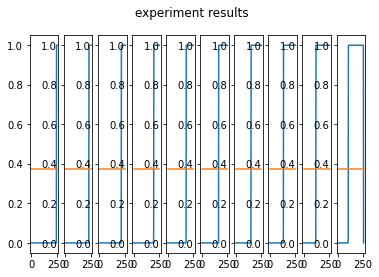

In [ ]:
model1 = build_transformer_model_1()

model1.fit(data, label, batch_size=BatchSize,
                   epochs=Generations, validation_data = (valD, valL),
                   verbose=2, shuffle=True)



prediction1 = model1.predict(valD)
make_binary_confusion_matrix(valL, prediction1)
visualize(valL, prediction1)

Epoch 1/16
653/653 - 215s - loss: 0.6683 - precision_1: 0.3492 - recall_1: 0.0026 - val_loss: 0.6708 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/16
653/653 - 181s - loss: 0.6669 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.6668 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/16
653/653 - 181s - loss: 0.6666 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.6667 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/16
653/653 - 181s - loss: 0.6664 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.6666 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/16
653/653 - 181s - loss: 0.6664 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.6669 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 6/16
653/653 - 181s - loss: 0.6663 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 0.6667 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 7/16
6

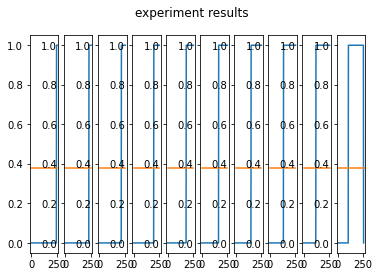

In [ ]:
del model1
model2 = build_transformer_model_2()

model2.fit(data, label, batch_size=BatchSize,
                   epochs=Generations, validation_data = (valD, valL),
                   verbose=2, shuffle=True)

prediction2 = model2.predict(valD)
make_binary_confusion_matrix(valL, prediction2)
visualize(valL, prediction2)

#unnecessary